# Identifying Fraudulent Activities
## Goal :

E-commerce websites often transact huge amounts of money. And whenever a huge amount of
money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen
credit cards, doing money laundry, et􀁊.
Machine Learning really excels at identifying fraudulent activities. Any website where you put
your credit card information has a risk team in charge of avoiding frauds via machine learning.
The goal of this challenge is to build a machine learning model that predicts the probability that
the first transaction of a new user is fraudulent.

## Challenge Description :

Company XYZ is an e-commerce site that sells hand-made clothes.
You have to build a model that predicts whether a user has a high probability of using the site to
perform some illegal activity or not. This is a super common task for data scientists.
You only have information about the user first transaction on the site and based on that you
have to make your classification ("fraud/no fraud").

## These are the tasks you are asked to do:
For each user, determine her country based on the numeric IP address.
Build a model to predict whether an activity is fraudulent or not. Explain how different
assumptions about the cost of false positives vs false negatives would impact the model.
Your boss is a bit worried about using a model she doesn't understand for something as
important as fraud detection. How would you explain her how the model is making the
predictions? Not from a mathematical perspective (she couldn't care less about that), but
from a user perspective. What kinds of users are more likely to be classified as at risk?
What are their characteristics?
Let's say you now have this model which can be used live to predict in real time if an
activity is fraudulent or not. From a product perspective, how would you use it?

In [97]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc,roc_auc_score, roc_curve, classification_report

In [49]:
address = pd.read_csv("IpAddress_to_Country.csv")
data = pd.read_csv("Fraud_Data.csv")

In [50]:
address.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [51]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [52]:
address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [54]:
address.describe()

,lower_bound_ip_address,upper_bound_ip_address
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


In [55]:
data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


# EDA

In [56]:
def match_ip_vectorized(data, address):
    ip_addresses = data['ip_address'].values
    lower_bounds = address['lower_bound_ip_address'].values
    upper_bounds = address['upper_bound_ip_address'].values
    countries = address['country'].values
    result_countries = np.full(len(ip_addresses), 'Unknown', dtype=object)
    for i, (lower, upper, country) in enumerate(zip(lower_bounds, upper_bounds, countries)):
        mask = (ip_addresses >= lower) & (ip_addresses <= upper)
        result_countries[mask] = country
    return result_countries

data['country'] = match_ip_vectorized(data, address)


In [57]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
 11  country         151112 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


In [59]:
for col in data.columns:
    print(data[col].value_counts())

user_id
138208    1
22058     1
333320    1
1359      1
150084    1
         ..
79203     1
73884     1
199700    1
182338    1
159045    1
Name: count, Length: 151112, dtype: int64
signup_time
2015-06-10 07:02:20    1
2015-02-24 22:55:49    1
2015-06-07 20:39:50    1
2015-01-01 18:52:44    1
2015-04-28 21:13:25    1
                      ..
2015-06-16 21:19:35    1
2015-05-29 16:22:02    1
2015-07-11 18:26:54    1
2015-01-25 17:49:49    1
2015-04-21 23:38:34    1
Name: count, Length: 151112, dtype: int64
purchase_time
2015-07-17 23:22:55    3
2015-06-08 09:42:04    3
2015-09-10 09:04:53    3
2015-08-13 16:27:53    2
2015-07-03 02:48:14    2
                      ..
2015-03-24 18:27:23    1
2015-11-12 22:08:11    1
2015-07-20 00:11:52    1
2015-10-03 02:21:46    1
2015-09-09 18:40:53    1
Name: count, Length: 150679, dtype: int64
purchase_value
28     3328
27     3196
32     3174
24     3152
26     3145
       ... 
121       1
122       1
132       1
140       1
125       1
Name: count

In [60]:
categorical_cols = ['device_id', 'source', 'browser', 'sex', 'country']
for col in categorical_cols:
    unique_count = data[col].nunique()
    print(f"{col}: {unique_count:,} unique values")

device_id: 137,956 unique values
source: 3 unique values
browser: 5 unique values
sex: 2 unique values
country: 182 unique values


In [61]:
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])

In [62]:
time_diff = data['purchase_time'] - data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['time_diff'] = time_diff

In [63]:
data['device_num'] = data.groupby('device_id')['user_id'].transform('count')

In [64]:
data['ip_num'] = data.groupby('ip_address')['user_id'].transform('count')

In [65]:
data['signup_day'] = data['signup_time'].dt.dayofweek
data['signup_week'] = data['signup_time'].dt.isocalendar().week

In [66]:
data['purchase_day'] = data['purchase_time'].dt.dayofweek
data['purchase_week'] = data['purchase_time'].dt.isocalendar().week

In [67]:
data = data.drop(columns=['purchase_time','signup_time'])

In [68]:
data.head()

,user_id,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown,60085,1,1,1,18,0,19
4,221365,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


In [70]:
X = data.drop(['class', 'user_id'], axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training: {y_train.value_counts(normalize=True)}")
print(f"Test: {y_test.value_counts(normalize=True)}")

Training: class
0    0.906352
1    0.093648
Name: proportion, dtype: float64
Test: class
0    0.906363
1    0.093637
Name: proportion, dtype: float64


In [81]:
from sklearn.preprocessing import OrdinalEncoder

categorical_cols = ['device_id', 'source', 'browser', 'sex', 'country']
encoders = {}

for col in categorical_cols:
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train[col] = encoder.fit_transform(X_train[[col]]).astype(int)
    X_test[col] = encoder.transform(X_test[[col]]).astype(int)
    encoders[col] = encoder

In [87]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train.astype('float32'), y_train.astype('int'))

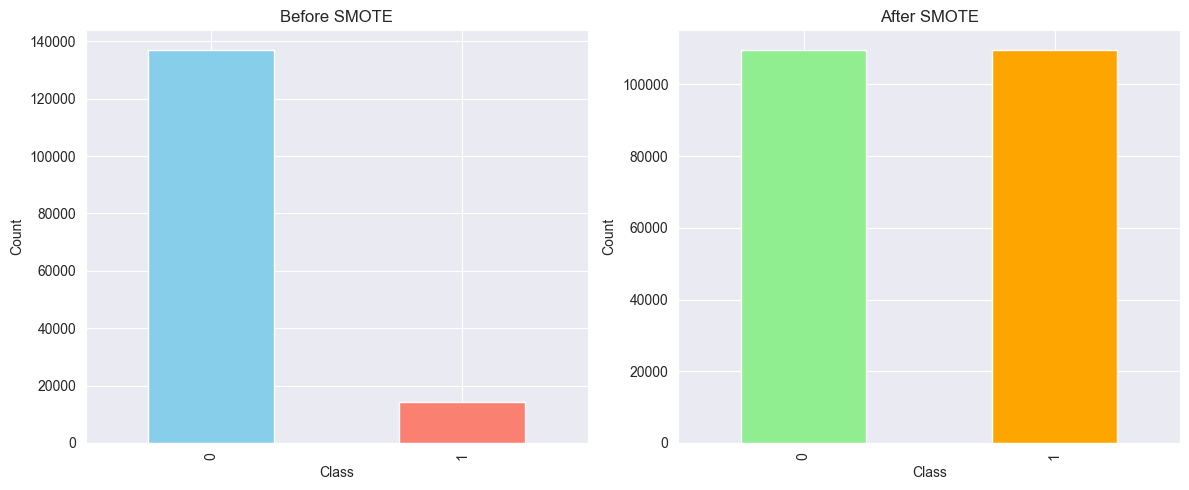

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
y.value_counts().plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Before SMOTE')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')

# After SMOTE
pd.Series(y_train_smote).value_counts().plot(kind='bar', ax=ax2, color=['lightgreen', 'orange'])
ax2.set_title('After SMOTE')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [90]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=None)

In [91]:
rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [92]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

In [95]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.99      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.97      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223



In [98]:
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.3f}")

ROC-AUC: 0.841


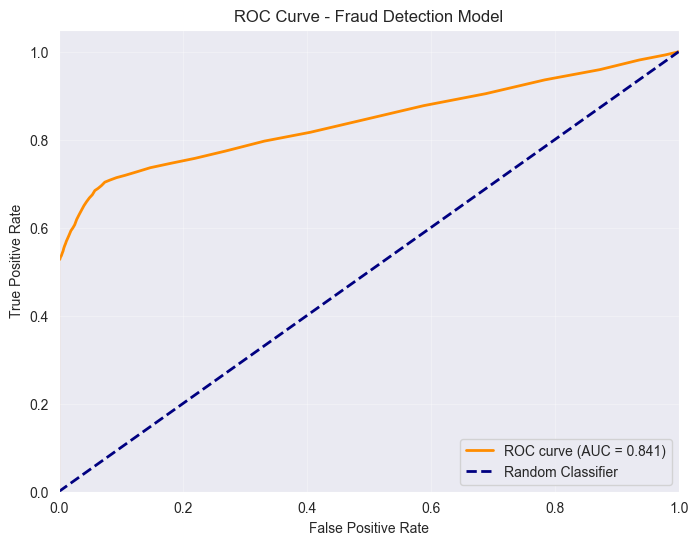

In [99]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Fraud Detection Model')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [100]:
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[27373    20]
 [ 1338  1492]]



Top 10 Feature Importances:
          feature  importance
9      device_num    0.308333
10         ip_num    0.172508
8       time_diff    0.077725
2          source    0.072109
14  purchase_week    0.071766
4             sex    0.067357
12    signup_week    0.055884
3         browser    0.048098
13   purchase_day    0.029602
11     signup_day    0.029321


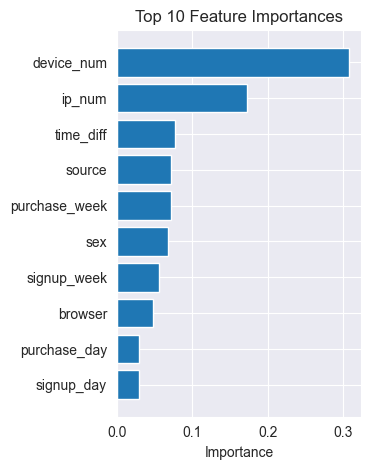

In [101]:
feature_importance = pd.DataFrame({
   'feature': X_train.columns,
   'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
print(f"\nTop 10 Feature Importances:")
print(feature_importance.head(10))
plt.subplot(1, 2, 2)
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Task 3: Explaining the Model to Your Boss:
what our model is showing us about users who are more likely to be at risk Legitimate customers usually use their own phones or computers while fraudsters often share devices like in internet cafes or stolen phones or even organized rings where many people use the same equipment When we see five or more users on the same device the chance of fraud goes up a lot

Another thing we notice is IP address patterns Multiple accounts coming from the same location can be a sign of fraud rings but of course places like corporate offices or universities have many users from the same IP and they are completely legitimate

We also see that the way people make purchases matters Normal customers take time to browse think and then buy while fraudsters try to complete transactions as fast as possible before stolen cards get blocked So when someone makes a purchase within minutes of signing up it is a strong warning

The big questions for us are should we block these users automatically or just flag them for review What is worse missing fraud or frustrating good customers Do we want to catch half of the fraud with almost no false alarms or catch more even if it bothers some real users

# Task 4: Product Implementation - Using the Model Live

Now that we have a model that can predict fraud in real time we can use it to make the product safer and smoother for our customers We can check every transaction at checkout to catch suspicious payments we can flag risky account creations early before any damage happens and we can monitor login events to detect account takeovers before they cause trouble For users who are low risk the model can let them go through normally without any friction for those in the medium risk range we can ask for extra verification like an SMS code or email confirmation or step up authentication so they verify their identity and we can manually review high value purchases For high risk users we can block transactions and immediately alert the fraud team and freeze accounts until everything is verified

The big questions we have to think about are how fast the model can score a transaction can we do it in under a hundred milliseconds how do we help customers who are wrongly blocked how do we continuously improve the model as new fraud patterns appear and what do we tell customers when we have to stop a transaction so they understand without frustration